In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import corner

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

# Basic hierarchical model

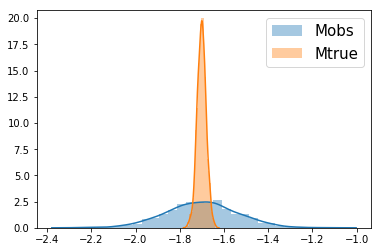

In [2]:
npts = 1000
rmu = -1.7
rsig = .02
runc = .1 #fractional uncertainty

Mtrue = np.random.randn(npts)*rsig + rmu
Munc = np.abs(Mtrue*runc)
Mobs = Mtrue + np.random.randn(npts)*Munc


sns.distplot(Mobs, label='Mobs')
sns.distplot(Mtrue, label='Mtrue')
plt.legend(fontsize=15)
plt.show()

Lets compare our likelihood to our posteriors

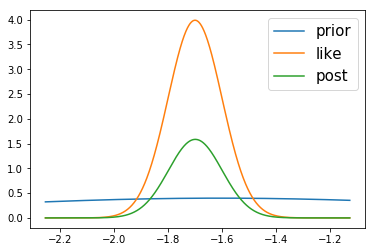

Median prior:-1.6096844112157256
Median like:-1.7001304626990263
Median post:-1.6989998870554852


In [3]:
x = np.linspace(Mobs.min(), Mobs.max(), 1000)
li = normal(x, rmu, runc)
pr = normal(x, -1.61, 1.)
plt.plot(x, pr, label='prior')
plt.plot(x, li, label='like')
plt.plot(x, li*pr, label='post')
plt.legend(fontsize=15)
plt.show()
print('Median prior:' +str(x[np.argmax(pr)]))
print('Median like:' +str(x[np.argmax(li)]))
print('Median post:' +str(x[np.argmax(li*pr)]))

In [4]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N)
        Mtrue[n] = mu + sigma * Mtrue_std[n];
}
model{
    mu ~ normal(-1.61, .1);
    sigma ~ normal(.1, .05);

    Mobs ~ normal(Mtrue, Munc);
    Mtrue_std ~ normal(0, 1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7314dc4b31e9e5ecc2f7c907fb19d015 NOW.


In [ ]:
data = {'N': npts,
       'Mobs':Mobs,
       'Munc':Munc}
init = {'mu':rmu,
       'sigma':rsig}
mus = np.zeros(100)
for idx in range(len(mus)):
    fit = sm.sampling(data=data, iter=1000, chains=2, init=[init, init])
    mus[idx] = np.median(fit['mus'])
sns.distplot(mus)

//anaconda/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


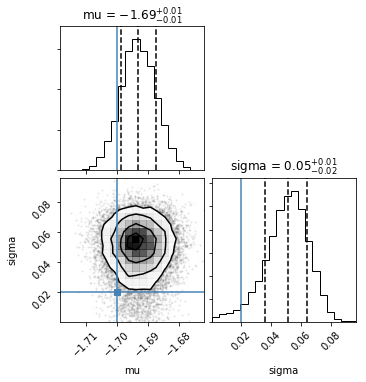

In [6]:
import corner
chain = np.array([fit['mu'],fit['sigma']]).T
truths=[rmu, rsig]
corner.corner(chain,labels=['mu','sigma'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

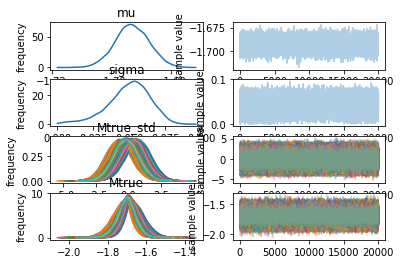

In [7]:
fit.plot()
plt.show()

In [8]:
print(fit)

Inference for Stan model: anon_model_7314dc4b31e9e5ecc2f7c907fb19d015.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              -1.69  4.0e-5 5.7e-3   -1.7   -1.7  -1.69  -1.69  -1.68  20000    1.0
sigma            0.05  2.8e-4   0.01   0.02   0.04   0.05   0.06   0.07 2748.0    1.0
Mtrue_std[0]     0.33  6.7e-3   0.95  -1.54  -0.31   0.33   0.98   2.19  20000    1.0
Mtrue_std[1]     0.03  6.7e-3   0.95  -1.86  -0.61   0.02   0.66   1.91  20000    1.0
Mtrue_std[2]     0.21  6.9e-3   0.98  -1.71  -0.44   0.21   0.87    2.1  20000    1.0
Mtrue_std[3]     0.18  6.8e-3   0.96  -1.68  -0.47   0.19   0.83   2.04  20000    1.0
Mtrue_std[4]    -0.48  6.9e-3   0.98  -2.37  -1.14  -0.48   0.18   1.44  20000    1.0
Mtrue_std[5]     0.33  6.8e-3   0.96  -1.56  -0.32   0.33   0.98   2.21  20000    1.0
Mtrue_std[6]     0.31  6.8e-3   0.9

# Hierarchical Mixture Model

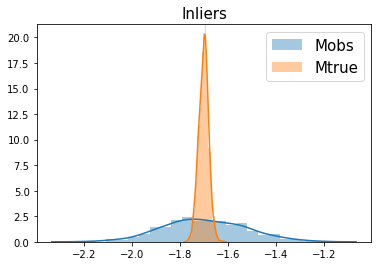

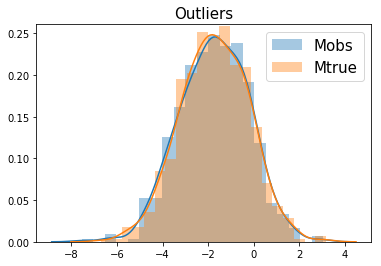

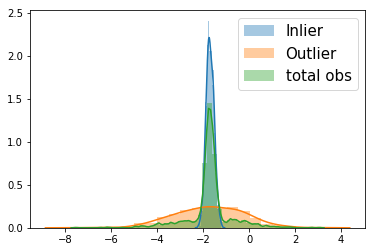

In [9]:
npts = 1000
rmu = -1.7
rsig = .02
runc = .1 #fractional uncertainty

iMtrue = np.random.randn(npts)*rsig + rmu
iMunc = np.abs(iMtrue*runc)
iMobs = iMtrue + np.random.randn(npts)*iMunc

sns.distplot(iMobs, label='Mobs')
sns.distplot(iMtrue, label='Mtrue')
plt.title('Inliers', fontsize=15)
plt.legend(fontsize=15)
plt.show()

rQ = .6
rmuo = rmu
rsigo = 1.5
onpts = int(npts*rQ)

oMtrue = np.random.randn(onpts)*rsigo + rmuo
oMunc = np.abs(oMtrue*runc)
oMobs = oMtrue + np.random.randn(onpts)*oMunc

sns.distplot(oMobs, label='Mobs')
sns.distplot(oMtrue, label='Mtrue')
plt.title('Outliers', fontsize=15)
plt.legend(fontsize=15)
plt.show()

Mobs = np.append(iMobs, oMobs)
Munc = np.append(iMunc, oMunc)

sns.distplot(iMobs, label='Inlier')
sns.distplot(oMobs, label='Outlier')
sns.distplot(Mobs, label='total obs')
plt.legend(fontsize=15)
plt.show()

In [10]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real<lower=.3> sigo;
    real Mtrue_std[N];
    real<lower=0, upper=1.> Q;
}
transformed parameters{
    real Mtrue[N];
    real transformed_sigmao;
    
    for (n in 1:N)
        Mtrue[n] = mu + sigma * Mtrue_std[n];
    transformed_sigmao = sigo/sigma;
}
model{
    mu ~ normal(-1.61, .1);
    sigma ~ normal(.1, .05);
    sigo ~ normal(1.5, .5);

    Mobs ~ normal(Mtrue, Munc);
    for (n in 1:N)
        target += log_mix(Q,
                normal_lpdf(Mtrue_std | 0, 1),
                normal_lpdf(Mtrue_std | 0, transformed_sigmao));

}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac12530b495987ad60ae394d4461c5cb NOW.


In [14]:
npts+onpts
len(Munc)

1600

In [ ]:
data = {'N': npts+onpts,
       'Mobs':Mobs,
       'Munc':Munc}
init = {'mu':rmu,
       'sigma':rsig,
        'sigo':rsigo,
       'Q':rQ}

fit = sm.sampling(data=data, iter=2000, chains=2, init=[init, init])

In [ ]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsig, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
fit.plot()
plt.show()

In [ ]:
print(fit)